<a id=top-page></a>
# `pykitPIV` demo: Local feature size estimation for PIV images

<div class="alert alert-block alert-info" style="margin-top: 20px">
<font size="3"><strong>Table of contents:</strong></font>
<br>
<ol>
    <li><a href="#generate-particles">Generate particles</a></li>
    <li><a href="#feature-size">Run the local feature size estimation tool</a></li>
</ol>
<p></p>
</div>
<br>

***

In [1]:
import matplotlib.pyplot as plt

In [56]:
import numpy as np
import time
import cmcrameri.cm as cmc
import matplotlib
import matplotlib.pyplot as plt
from pykitPIV import Particle, Image
from PCAfold import reduction, analysis

In [3]:
n_images = 1

In [62]:
image_size = (128,128)

In [63]:
size_buffer = 0

In [64]:
figsize = (6,3)

<a id=generate-particles></a>
***

## Generate particles

[Go to the top](#top-page)

In [202]:
particles = Particle(n_images, 
                     size=image_size, 
                     size_buffer=size_buffer,
                     diameters=(3,3.1),
                     distances=(1,2),
                     densities=(0.05,0.1),
                     signal_to_noise=(5,20),
                     diameter_std=0.2,
                     seeding_mode='random', 
                     random_seed=100)

In [203]:
image = Image(random_seed=100)

In [204]:
image.add_particles(particles)

Particles added to the image.


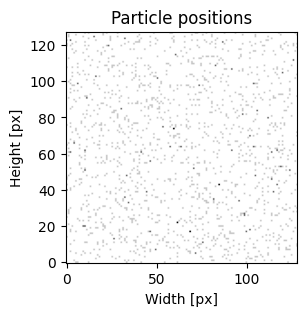

In [205]:
image.plot(0, 
           with_buffer=True,
           xlabel='Width [px]',
           ylabel='Height [px]',
           title='Particle positions',
           cmap='Greys',
           figsize=figsize, 
           filename='particle-positions.png');

In [206]:
image.add_reflected_light(exposures=(0.6,0.65),
                          maximum_intensity=2**16-1,
                          laser_beam_thickness=1,
                          laser_over_exposure=1,
                          laser_beam_shape=0.95,
                          alpha=1/10)

Reflected light added to images I1.


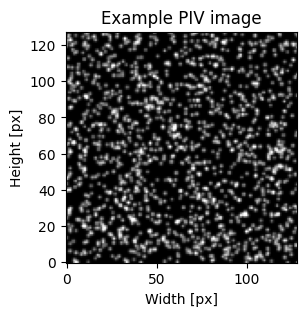

In [207]:
image.plot(0, 
           with_buffer=True,
           xlabel='Width [px]',
           ylabel='Height [px]',
           title='Example PIV image',
           cmap='Greys_r',
           figsize=figsize, 
           filename='example-image.png');

<a id=feature-size></a>
***

## Run the local feature size estimation tool

[Go to the top](#top-page)

In [208]:
x = np.linspace(0,1,image_size[0])
y = np.linspace(0,1,image_size[1])

In [209]:
grid_x, grid_y = np.meshgrid(x, y)

In [210]:
grid = np.hstack((grid_x.ravel()[:,None], grid_y.ravel()[:,None]))

In [211]:
depvar_names = ['I0']

In [212]:
depvar = image.images_I1[0].ravel()[:,None]

In [213]:
bandwidth_values = np.logspace(-6,0,100)

In [214]:
tic = time.perf_counter()

variance_data = analysis.compute_normalized_variance(grid,
                                                     depvars=depvar,
                                                     depvar_names=depvar_names,
                                                     bandwidth_values=bandwidth_values,
                                                     compute_sample_norm_range=True)

toc = time.perf_counter()
print(f'Time it took: {(toc-tic)/60:0.1f} minutes.\n')

Time it took: 2.3 minutes.



In [215]:
derivative, sigmas, _ = analysis.normalized_variance_derivative(variance_data)
derivatives = derivative['I0']

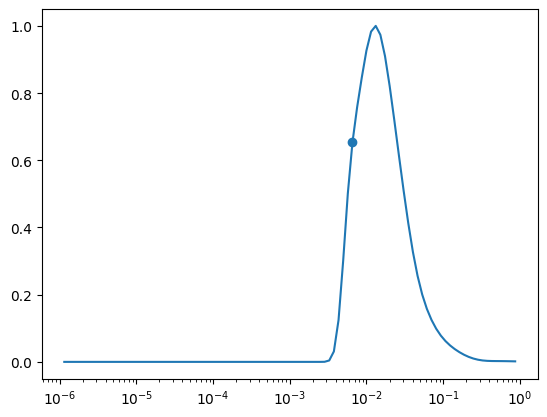

In [216]:
plt.semilogx(sigmas, derivatives)
plt.scatter(sigmas[62], derivatives[62])

In [222]:
feature_size_map = analysis.feature_size_map(variance_data, 
                                             variable_name='I0', 
                                             cutoff=10, 
                                             starting_bandwidth_idx='peak', 
                                             use_variance=False, 
                                             verbose=True)

Rightmost peak at index 67 is used as the starting bandwidth.

Feature sizes will be computed starting from size:
0.013219411484660288
where the normalized variance derivative is equal to:
1.0


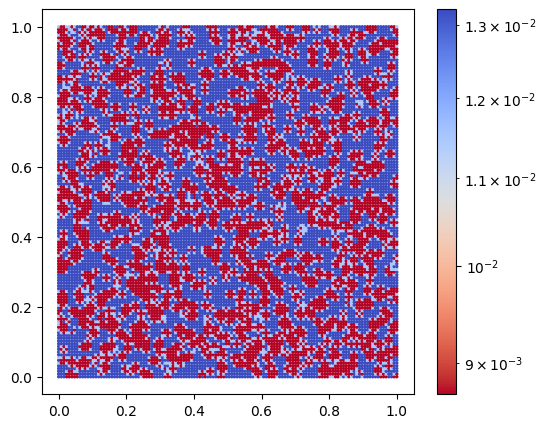

In [223]:
plt.figure(figsize=(6,5))
plt.scatter(grid[:,0], 
            grid[:,1], 
            s=2,
            c=feature_size_map, 
            norm=matplotlib.colors.LogNorm(), 
            cmap='coolwarm_r')

cbar = plt.colorbar(aspect=20)

In [224]:
I0_feature_size = np.reshape(feature_size_map, image_size)

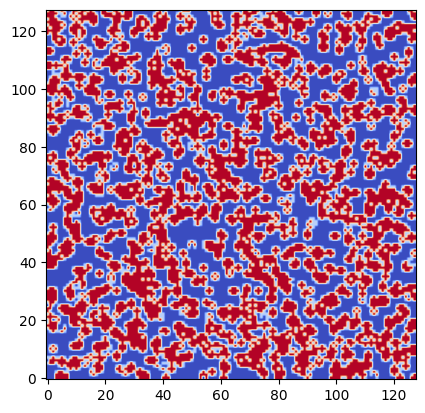

In [225]:
plt.imshow(I0_feature_size, origin='lower', cmap='coolwarm_r')

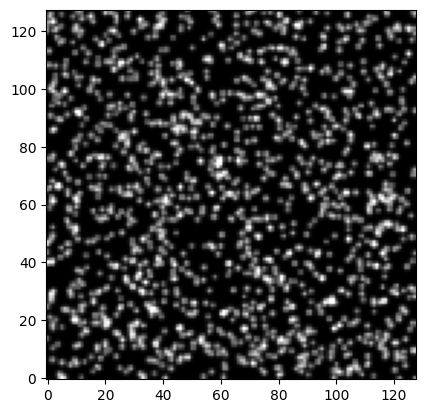

In [226]:
plt.imshow(image.images_I1[0], origin='lower', cmap='Greys_r')

***